In [29]:
from ortools.graph.python import max_flow
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp
import time
import random

# Paper Reviewer Assignment
## Problem Description
The chair of a conference must assign scientific papers to reviewers in a balance way. There are $N$ papers $1, 2, …, N$ and $M$ reviewers $1, 2, …, M$. 

- Each paper i has a list $L(i)$ of reviewers who are willing to review that paper. A review plan is an assignment reviewers to papers. The load of a reviewer is the number of papers he/she have to review. Given a constant b, compute the assignment such that:

- Each paper is reviewed by exactly b reviewers 

The maximum load of all reviewers is minimal
In the solution, each paper i is represented by a list $r(i, 1), r(i, 2), . . ., r(i, b)$ of b reviewers asssigned to this paper
## Model Formulation
### Set and Indices
$Papers=\{i : i \in (1,2,3,...,N)\}$: Set of Papers

$Reviewers=\{ j: j \in (1,2,3,...,M)\}$: Set of Reviewers

$Pairings=\{(i,j) \in Papers \times Reviewers \}$: Set of all possible paper-reviewer assignments

$ G=(Papers,Reviewers, Pairings)$: A bipartite graph where the set of nodes is divided into two disjoint sets: Papers and Reviewers, and Pairings represents the set of edges connecting each paper to its potential reviewers.

### Parameters
### Decision Variables
- The variables 
$
x_{i,j} =
\begin{cases}
1 & \text{if paper } i \text{ is assigned by reviewer } j, \\
0 & \text{otherwise}.
\end{cases}
$
- The load of each reviewers $L(i) \forall i \in \{1,2,...,n\}$
### Constraints 
- Each paper is reviewed by exactly $b$ reviewers

\begin{equation}
\sum_{(i,j) \in \text{Pairings}}x_{i,j} = b \quad \forall  i \in Papers
\tag{1}
\end{equation}
- The load of each reviewers

\begin{equation}
 L(j) = \sum_{(i,j) \in \text{Pairings}} x_{i,j}  \quad \forall j \in \text{Reviewers}
\tag{2}
\end{equation}
- Get max load  
\begin{equation}
M = \max \left( L(j) \mid j \in \text{Reviewers} \right)
\tag{3}
\end{equation}

### Object function
The maximum load of all reviewers is minimal

\begin{equation}
 \text{Min  } M
\tag{0}
\end{equation}

## Method
- ### Mixed Intger Programing
- ### Constraints Programing
- ### Max Flow
- ### Greedy
- ### Hybrid: Greedy + Local search
- ### Linear Programing + Randomized Rouding

### Reading Input Data 

In [30]:
def input_data():
    with open('input.txt', 'r') as f:
        num_papers,num_reviewers,reviews_per_paper = map(int, f.readline().strip().split())
        willing_reviewers = {}
        for i in range(num_papers):
            line = list(map(int, f.readline().strip().split()))
            paper_id = i+1
            reviewers = line[1:]
            willing_reviewers[paper_id] = reviewers
    return num_papers, num_reviewers, reviews_per_paper, willing_reviewers
def reverse_dict(willing_reviewers):
    willing_papers = {}
    for paper, reviewers in willing_reviewers.items():
        for reviewer in reviewers:
            if reviewer not in willing_papers:
                willing_papers[reviewer] = []
            willing_papers[reviewer].append(paper)
    return willing_papers




### Calculate Execution Time

In [31]:
def time_execution(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.4f} seconds")
        return result
    return wrapper

# 1. Mixed Interger Programming Model with OR-Tools

In [32]:
@time_execution
def Interger_Programming():
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()  
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    
    x = {}
    for paper in range(1, num_papers + 1):
        for reviewer in willing_reviewers[paper]:
            x[(paper, reviewer)] = solver.BoolVar(f'x[{paper},{reviewer}]')

    # Ràng buộc: Mỗi paper phải được đánh giá bởi đúng số lượng reviewers
    for paper in range(1, num_papers + 1):
        solver.Add(solver.Sum(x[(paper, reviewer)] for reviewer in willing_reviewers[paper]) == reviews_per_paper)

    # Ràng buộc: Tải của mỗi reviewer
    loads = {}
    for reviewer in range(1, num_reviewers + 1):
        loads[reviewer] = solver.IntVar(0, num_papers, f'load[{reviewer}]')
        solver.Add(loads[reviewer] == solver.Sum(x[(paper, reviewer)] for paper in range(1, num_papers + 1) if (paper, reviewer) in x))
    
    # Ràng buộc: Tải tối đa của các reviewers là nhỏ nhất
    max_load = solver.IntVar(0, num_papers, 'max_load')
    for reviewer in range(1, num_reviewers + 1):
        solver.Add(loads[reviewer] <= max_load)

    # Hàm mục tiêu: Tối thiểu hóa tải tối đa
    solver.Minimize(max_load)

    # Giải bài toán
    status = solver.Solve()
    print(f'{status}')
    # In kết quả
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(max_load.solution_value())
        
    else:
        print('Không tìm được nghiệm tối ưu.')
# Tạo solver: MIP = Mixed Integer Programming
solver = pywraplp.Solver.CreateSolver('SCIP')

Interger_Programming()

KeyboardInterrupt: 

# 2. Constraint Programming Model with OR-Tools



In [ ]:
@time_execution
def Constraint_Programming()-> None:
    # Read input data
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()  
    # Create the model
    model = cp_model.CpModel()
    # Create binary variables for each paper-reviewer pair
    x= {}
    for paper in range(1, num_papers + 1):
        for reviewer in willing_reviewers[paper]:
            x[(paper, reviewer)] = model.NewBoolVar(f'x[{paper},{reviewer}]')

    # Each paper must be reviewed by exactly reviews_per_paper reviewers
    for paper in range(1, num_papers + 1):
        model.Add(sum(x[(paper, reviewer)] for reviewer in willing_reviewers[paper]) == reviews_per_paper)
    # Load for each reviewer
    loads = {}
    for reviewer in range(1, num_reviewers + 1):
        loads[reviewer] = model.NewIntVar(0, num_papers, f'load[{reviewer}]')
        model.Add(loads[reviewer] == sum(x[(paper, reviewer)] for paper in range(1, num_papers + 1) if (paper, reviewer) in x))
    
    # Add constraints max of loads is minium
    max_load = model.NewIntVar(0, num_papers, 'max_load')
    for reviewer in range(1, num_reviewers + 1):
        model.Add(loads[reviewer] <= max_load)

    # Objective: minimize the maximum load
    model.Minimize(max_load)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    # Print the solution
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        """print(num_papers)
        for paper in range(1, num_papers + 1):
            print(reviews_per_paper, end=' ')
            for reviewer in willing_reviewers[paper]:
                if solver.Value(x[(paper, reviewer)]) == 1:
                    print(reviewer, end=' ')
            print()"""
        print(solver.ObjectiveValue())
    else:
        print('No solution found.')
    
Constraint_Programming()

163.0
Execution time: 19.8386 seconds


# 3. Max Flow Model

## Prepare Data For Directed Graph Form
### Define the source node and sink node
    source = 0
    sink = num_papers + num_reviewers + 1
### Define the arcs
- The first type of arcs is from the source node to each paper node, with capacities equal to reviewers_per_paper
- The second type of arcs is from each paper node to its willing reviewers, with  capacities equal 1
- The third type of arcs is from each reviewer node to sink node, with capacities equal max of numbers papers, for each reviewer The maximum number of papers assigned to each reviewer.
We need to transport all data from source code to sink code: $data = num \_ papers \times reviewers\_ per \_ paper$

This is example visualizaion
![alt text](image.png)

In [8]:
def pre_processing_data(num_papers,num_reviewers,reviews_per_paper ,willing_reviewers,max_load):
    
    source = 0
    sink = num_papers + num_reviewers + 1

    start_nodes = []
    end_nodes = []
    capacities = []

    # Arcs from source to papers
    start_nodes += [source] * num_papers
    end_nodes += [i for i in range(1, num_papers + 1)]
    capacities += [reviews_per_paper] * num_papers

    # Arcs from papers to reviewers (with correct offset)
    for paper in range(1, num_papers + 1):
        for reviewer in willing_reviewers[paper]:
            start_nodes.append(paper)
            end_nodes.append(reviewer + num_papers)  # Add offset here
            capacities.append(1)

    # Arcs from reviewers to sink
    for reviewer in range(1, num_reviewers + 1):
        start_nodes.append(reviewer + num_papers)
        end_nodes.append(sink)
        capacities.append(max_load)
    return start_nodes, end_nodes, capacities

## Define the solution model
We use the graph-based solution model provided by the OR-Tools library. This model includes implementations of algorithms such as Dinic's algorithm and the Ford–Fulkerson algorithm, which can be more efficient and suitable for certain problems compared to Linear Programming or Constraint Programming approaches.

In [ ]:
@time_execution
def max_flow_method(): 
    # Instantiate a SimpleMaxFlow solver.
    smf = max_flow.SimpleMaxFlow()

    # Read input data
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()

    #Minimum capactices of max_load
    if (num_papers*reviews_per_paper) % num_reviewers == 0:
        low=(num_papers*reviews_per_paper) // num_reviewers
    else:
        low=(num_papers*reviews_per_paper) // num_reviewers + 1
    
    willing_papers = reverse_dict(willing_reviewers)
    willing_papers=dict(sorted(willing_papers.items(), key=lambda item: len(item[1])))
    high= max(len(papers) for papers in willing_papers.values()) if willing_papers else 0
        
    #Dirichlet's theorem
    max_load= low

    while max_load<=high:        
        start_nodes, end_nodes, capacities = pre_processing_data(num_papers,num_reviewers,reviews_per_paper ,willing_reviewers,max_load)
        #   note: we could have used add_arc_with_capacity(start, end, capacity)
        all_arcs = smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

        # Find the maximum flow between node 0 and node 4.
        status = smf.solve(0, num_papers + num_reviewers + 1)

        if (status == smf.OPTIMAL) and smf.optimal_flow()== num_papers * reviews_per_paper:
            # Print the solution
            """print(num_papers)
            solution_flows = smf.flows(all_arcs)
            arc_indices = {arc: i for i, arc in enumerate(zip(start_nodes, end_nodes))}
       
            for paper in range(1, num_papers + 1):
                print(reviews_per_paper, end=' ')
                assigned_reviewers = []
                
                # Check all arcs from this paper to reviewers
                for reviewer in willing_reviewers[paper]:
                    arc = (paper, reviewer + num_papers)
                    if arc in arc_indices:
                        flow_index = arc_indices[arc]
                        if solution_flows[flow_index] == 1:
                            assigned_reviewers.append(reviewer)
                
                # Print assigned reviewers
                for rev in assigned_reviewers[:reviews_per_paper]:  # Ensure we don't exceed required reviews
                    print(rev, end=' ')
                print()"""
            print(max_load) 
            break
        else:
            max_load += 1
        
max_flow_method()

163
Execution time: 0.0420 seconds


Now we go to approximation algorithms


# 4.  Greedy Algorithm
## Greedy 1
We prioritize willing reviewers for papers that currently have fewer assigned reviewers

For each paper in sorted dictionary, We randomly choice exact __reviews_per_paper__  reviewers

In [10]:
def matching_papers(num_papers, num_reviewers, reviews_per_paper, willing_reviewers):
    load = [0] * (num_reviewers + 1)
    sorted_dict = dict(sorted(willing_reviewers.items(), key=lambda item: len(item[1])))
    selected_reviewers = {}
    for paper,reviewers in sorted_dict.items():
        #Sort the reviewers by their current load
        reviewers.sort(key=lambda x: load[x])
        # Select the first K reviewers
        selected_reviewers[paper] = reviewers[:reviews_per_paper]
        # Update the load of the selected reviewers
        for reviewer in selected_reviewers[paper]:
            load[reviewer] += 1
    # Find the maximum load
    max_load = max(load[1:])
    return max_load, selected_reviewers
@time_execution
def greedy_method(): 
    # Read input data
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()
    
    # Call the matching function
    max_load, selected_reviewers = matching_papers(num_papers, num_reviewers, reviews_per_paper, willing_reviewers)
    
    # Print the result
    """print(num_papers)
    for paper in range(1, num_papers + 1):
        print(reviews_per_paper, end=' ')
        for reviewer in selected_reviewers.get(paper, []):
            print(reviewer, end=' ')
        print()"""
    print(max_load)
    
greedy_method() 

163
Execution time: 0.0430 seconds


## Greedy 2
For each paper in the sorted dictionary, we select __reviewers_per_paper__ reviewers.
To make the assignment more balanced, we prioritize reviewers with the minimum current load

# 5. Local Search 
We start with a base solution generated by a greedy algorithm, and then optimize this solution using local search.
## Define the neighbor
Two reviewers are considered neighbors if there exists at least one paper that both of them are willing to review.
## Algorithm
We select reviewer, with current load is maximum (__A__)  then for each of others, we prioritize reviewers with the minimum current load (__B__). If they are neighbors, we randomly select  __c__ in __avaiable_papers__  and swap ( reassign paper __c__ from reviewer __A__ to reviewer __B__ )

This algorithm stops when there is no further change in reviewer load. We repeat the algorithm for a sufficiently large number of iterations (__times__) to allow the solution to converge.



In [17]:
def matching_papers_2(num_papers, num_reviewers, reviews_per_paper, willing_reviewers):
    load = {i: 0 for i in range(1, num_reviewers + 1)}  # Fixed: Start from 1 instead of 0
    sorted_dict = dict(sorted(willing_reviewers.items(), key=lambda item: len(item[1])))
    selected_reviewers = {}
    for paper,reviewers in sorted_dict.items():
        #Sort the reviewers by their current load
        reviewers.sort(key=lambda x: load[x])
        # Select the first K reviewers
        selected_reviewers[paper] = reviewers[:reviews_per_paper]
        # Update the load of the selected reviewers
        for reviewer in selected_reviewers[paper]:
            load[reviewer] += 1
    # Find the maximum load
    max_load = max(load.values())
    return max_load, selected_reviewers, load

def local_search(num_papers, num_reviewers, reviews_per_paper, willing_papers, assigned_papers, current_load, times=0):
    if times > 100:  # Limit recursion depth
        return assigned_papers, current_load
    
    changed = False
    sorted_load = dict(sorted(current_load.items(), key=lambda item: item[1]))
    #get the max load
    reviewer_of_max_load = max(current_load, key=current_load.get)
    max_load = current_load[reviewer_of_max_load]
    
    for candidate in sorted_load.keys():
        if sorted_load[candidate] < max_load-1:
            # Ensure both reviewers exist in the dictionaries
            if candidate not in willing_papers:
                willing_papers[candidate] = []
            if reviewer_of_max_load not in assigned_papers:
                continue
                
            available_papers = list(set(willing_papers.get(candidate, [])) & set(assigned_papers[reviewer_of_max_load]))
            if len(available_papers) > 0:
                random_paper = random.choice(available_papers)
                assigned_papers[candidate].append(random_paper)
                assigned_papers[reviewer_of_max_load].remove(random_paper)
                # Update the load
                current_load[candidate] += 1
                current_load[reviewer_of_max_load] -= 1
                changed=True
                break
                
    if changed:
        return local_search(num_papers, num_reviewers, reviews_per_paper, willing_papers, assigned_papers, current_load, times+1)

    return assigned_papers, current_load
@time_execution
def local_search_method():
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()
    willing_papers = reverse_dict(willing_reviewers)

    
    max_load, selected_reviewers, current_load = matching_papers_2(num_papers, num_reviewers, reviews_per_paper, willing_reviewers)
    
    # Calculate assigned papers for each reviewer
    assigned_papers = reverse_dict(selected_reviewers)
    
    # Update willing papers by removing already assigned papers
    reviewer_willing_papers = {}
    for i in range(1, num_reviewers+1):
        if i in willing_papers:
            reviewer_willing_papers[i] = list(set(willing_papers[i]) - set(assigned_papers.get(i, [])))
    
    # Perform local search
    optimized_assignments, final_load = local_search(num_papers, num_reviewers, reviews_per_paper, reviewer_willing_papers, assigned_papers, current_load)
    selected_reviewers=reverse_dict(optimized_assignments)
    """print(num_papers)
    for paper, reviewers in selected_reviewers.items():
        print(f"{reviews_per_paper} {' '.join(map(str, reviewers))}")"""
    print(f"Max load: {max(final_load.values())}")

local_search_method()

Max load: 163
Execution time: 0.0780 seconds


# 6. Linear Programming + Randomized Rouding
Firstly, we start with a continuous-variable solution generated by a Linear Programming model, and then convert it into a discrete-variable solution using local search.



In [ ]:
@time_execution
def main()-> None:
    num_papers, num_reviewers, reviews_per_paper, willing_reviewers = input_data()  
    solver=pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        print("Solver not created.")
        return
    # Create binary variables for each paper-reviewer pair
    x = {}
    for paper in range(1, num_papers + 1):
        for reviewer in willing_reviewers[paper]:
            x[(paper, reviewer)] = solver.NumVar(0,1,f'x[{paper},{reviewer}]')
    loads= {}   
    for reviewer in range(1, num_reviewers + 1):
        loads[reviewer] = solver.NumVar(0, num_papers, f'load[{reviewer}]')
    for j in range(1,num_papers+1):
        solver.Add(solver.Sum(x[(j,i)] for i in willing_reviewers[j]) == reviews_per_paper)
    for i in range(1, num_reviewers + 1):
        solver.Add(loads[i] == solver.Sum(x[(j, i)] for j in range(1, num_papers + 1) if (j, i) in x))
    max_load = solver.NumVar(0, num_papers, 'max_load')
    for i in range(1, num_reviewers + 1):
        solver.Add(loads[i] <= max_load)
    solver.Minimize(max_load)
    
    # Solve the LP model
    status = solver.Solve()
    
    # Check if a solution was found
    if status != pywraplp.Solver.OPTIMAL and status != pywraplp.Solver.FEASIBLE:
        print('No solution found.')
        return
        
    # Print the LP solution
    print(f"LP Solution - Maximum load: {max_load.solution_value()}")
    
    # Randomized Rounding
    assignments = {}
    reviewer_counts = {r: 0 for r in range(1, num_reviewers + 1)}
    
    for paper in range(1, num_papers + 1):
        # Get the fractional solution values for this paper
        probabilities = []
        reviewers = []
        for reviewer in willing_reviewers[paper]:
            probabilities.append(x[(paper, reviewer)].solution_value())
            reviewers.append(reviewer)
        
        # Normalize probabilities (they should sum to reviews_per_paper)
        total = sum(probabilities)
        if total > 0:
            probabilities = [p/total for p in probabilities]
        # Select reviewers without replacement
        chosen = []
        for _ in range(reviews_per_paper):
            if not probabilities:  # In case all probabilities are zero
                remaining = [r for r in willing_reviewers[paper] if r not in chosen]
                if not remaining:
                    break
                r = random.choice(remaining)
            else:
                r = random.choices(reviewers, weights=probabilities, k=1)[0]
                while r in chosen:
                    # Resample if we get a duplicate (for cases where we sample with replacement)
                    r = random.choices(reviewers, weights=probabilities, k=1)[0]
            
            chosen.append(r)
            reviewer_counts[r] += 1
        
        assignments[paper] = chosen
    
    # Output the results
    print(f"{max(reviewer_counts.values())}")
    

if __name__ == "__main__":
    main()

LP Solution - Maximum load: 162.5609756097561
164
Execution time: 14.2064 seconds


# Analysis

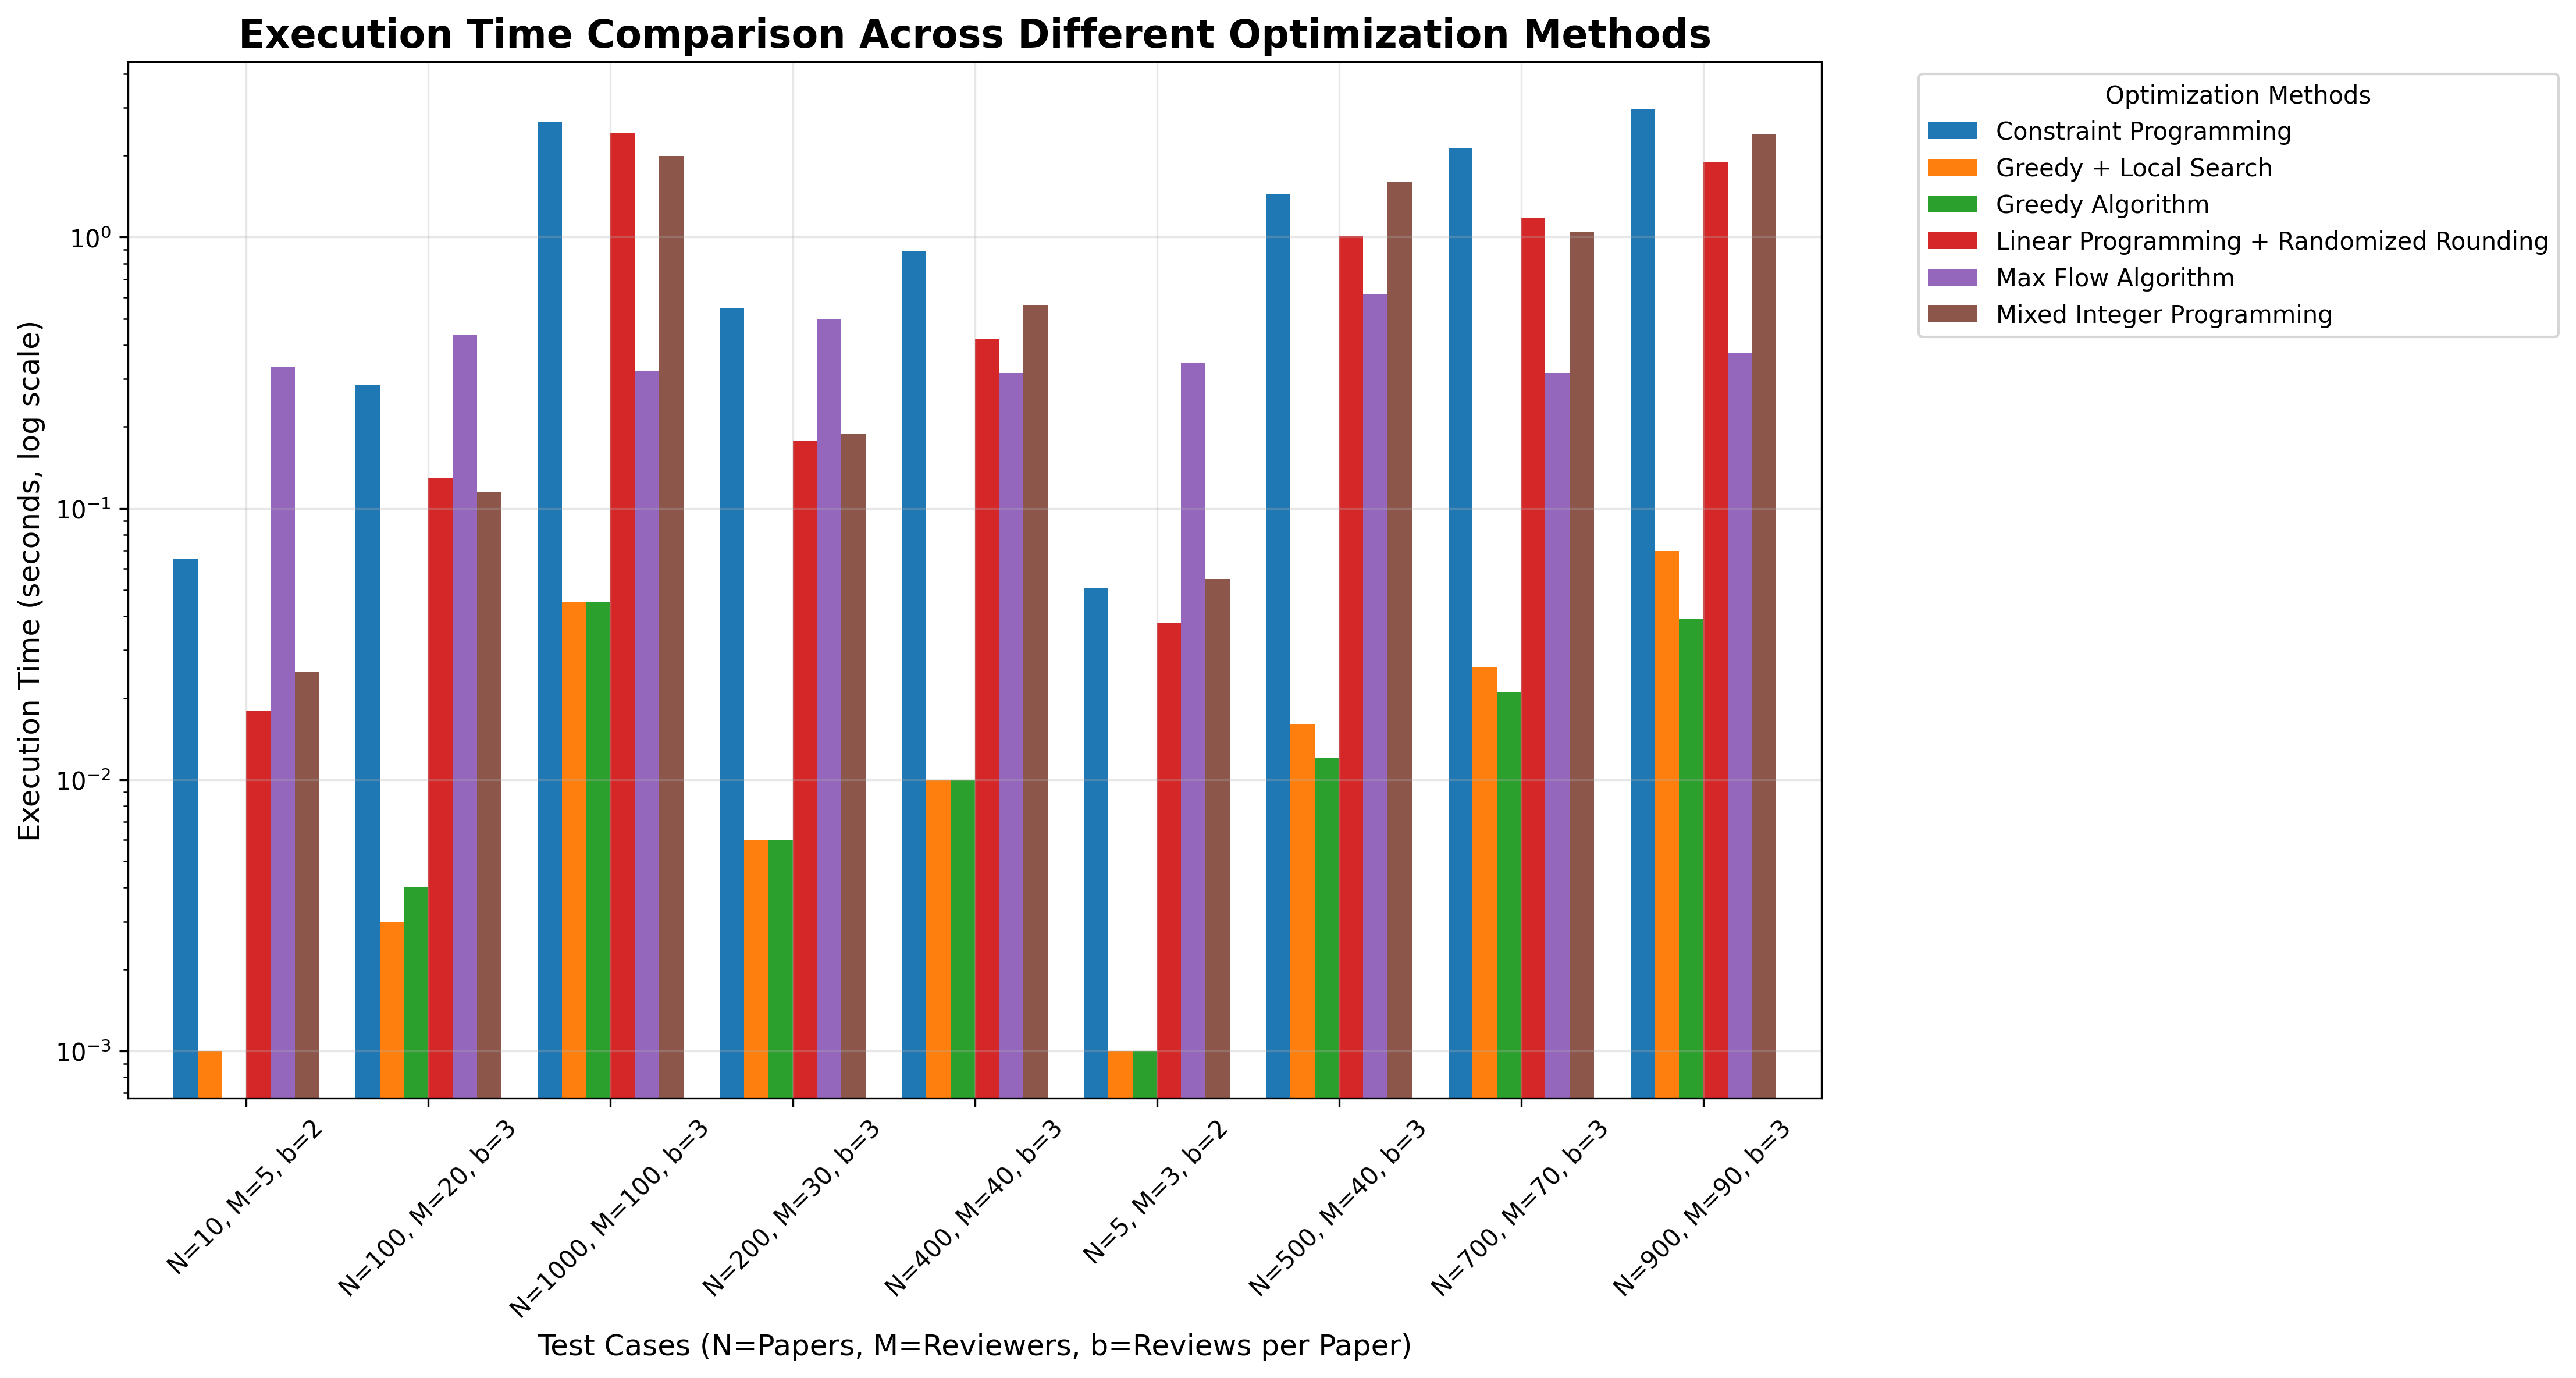
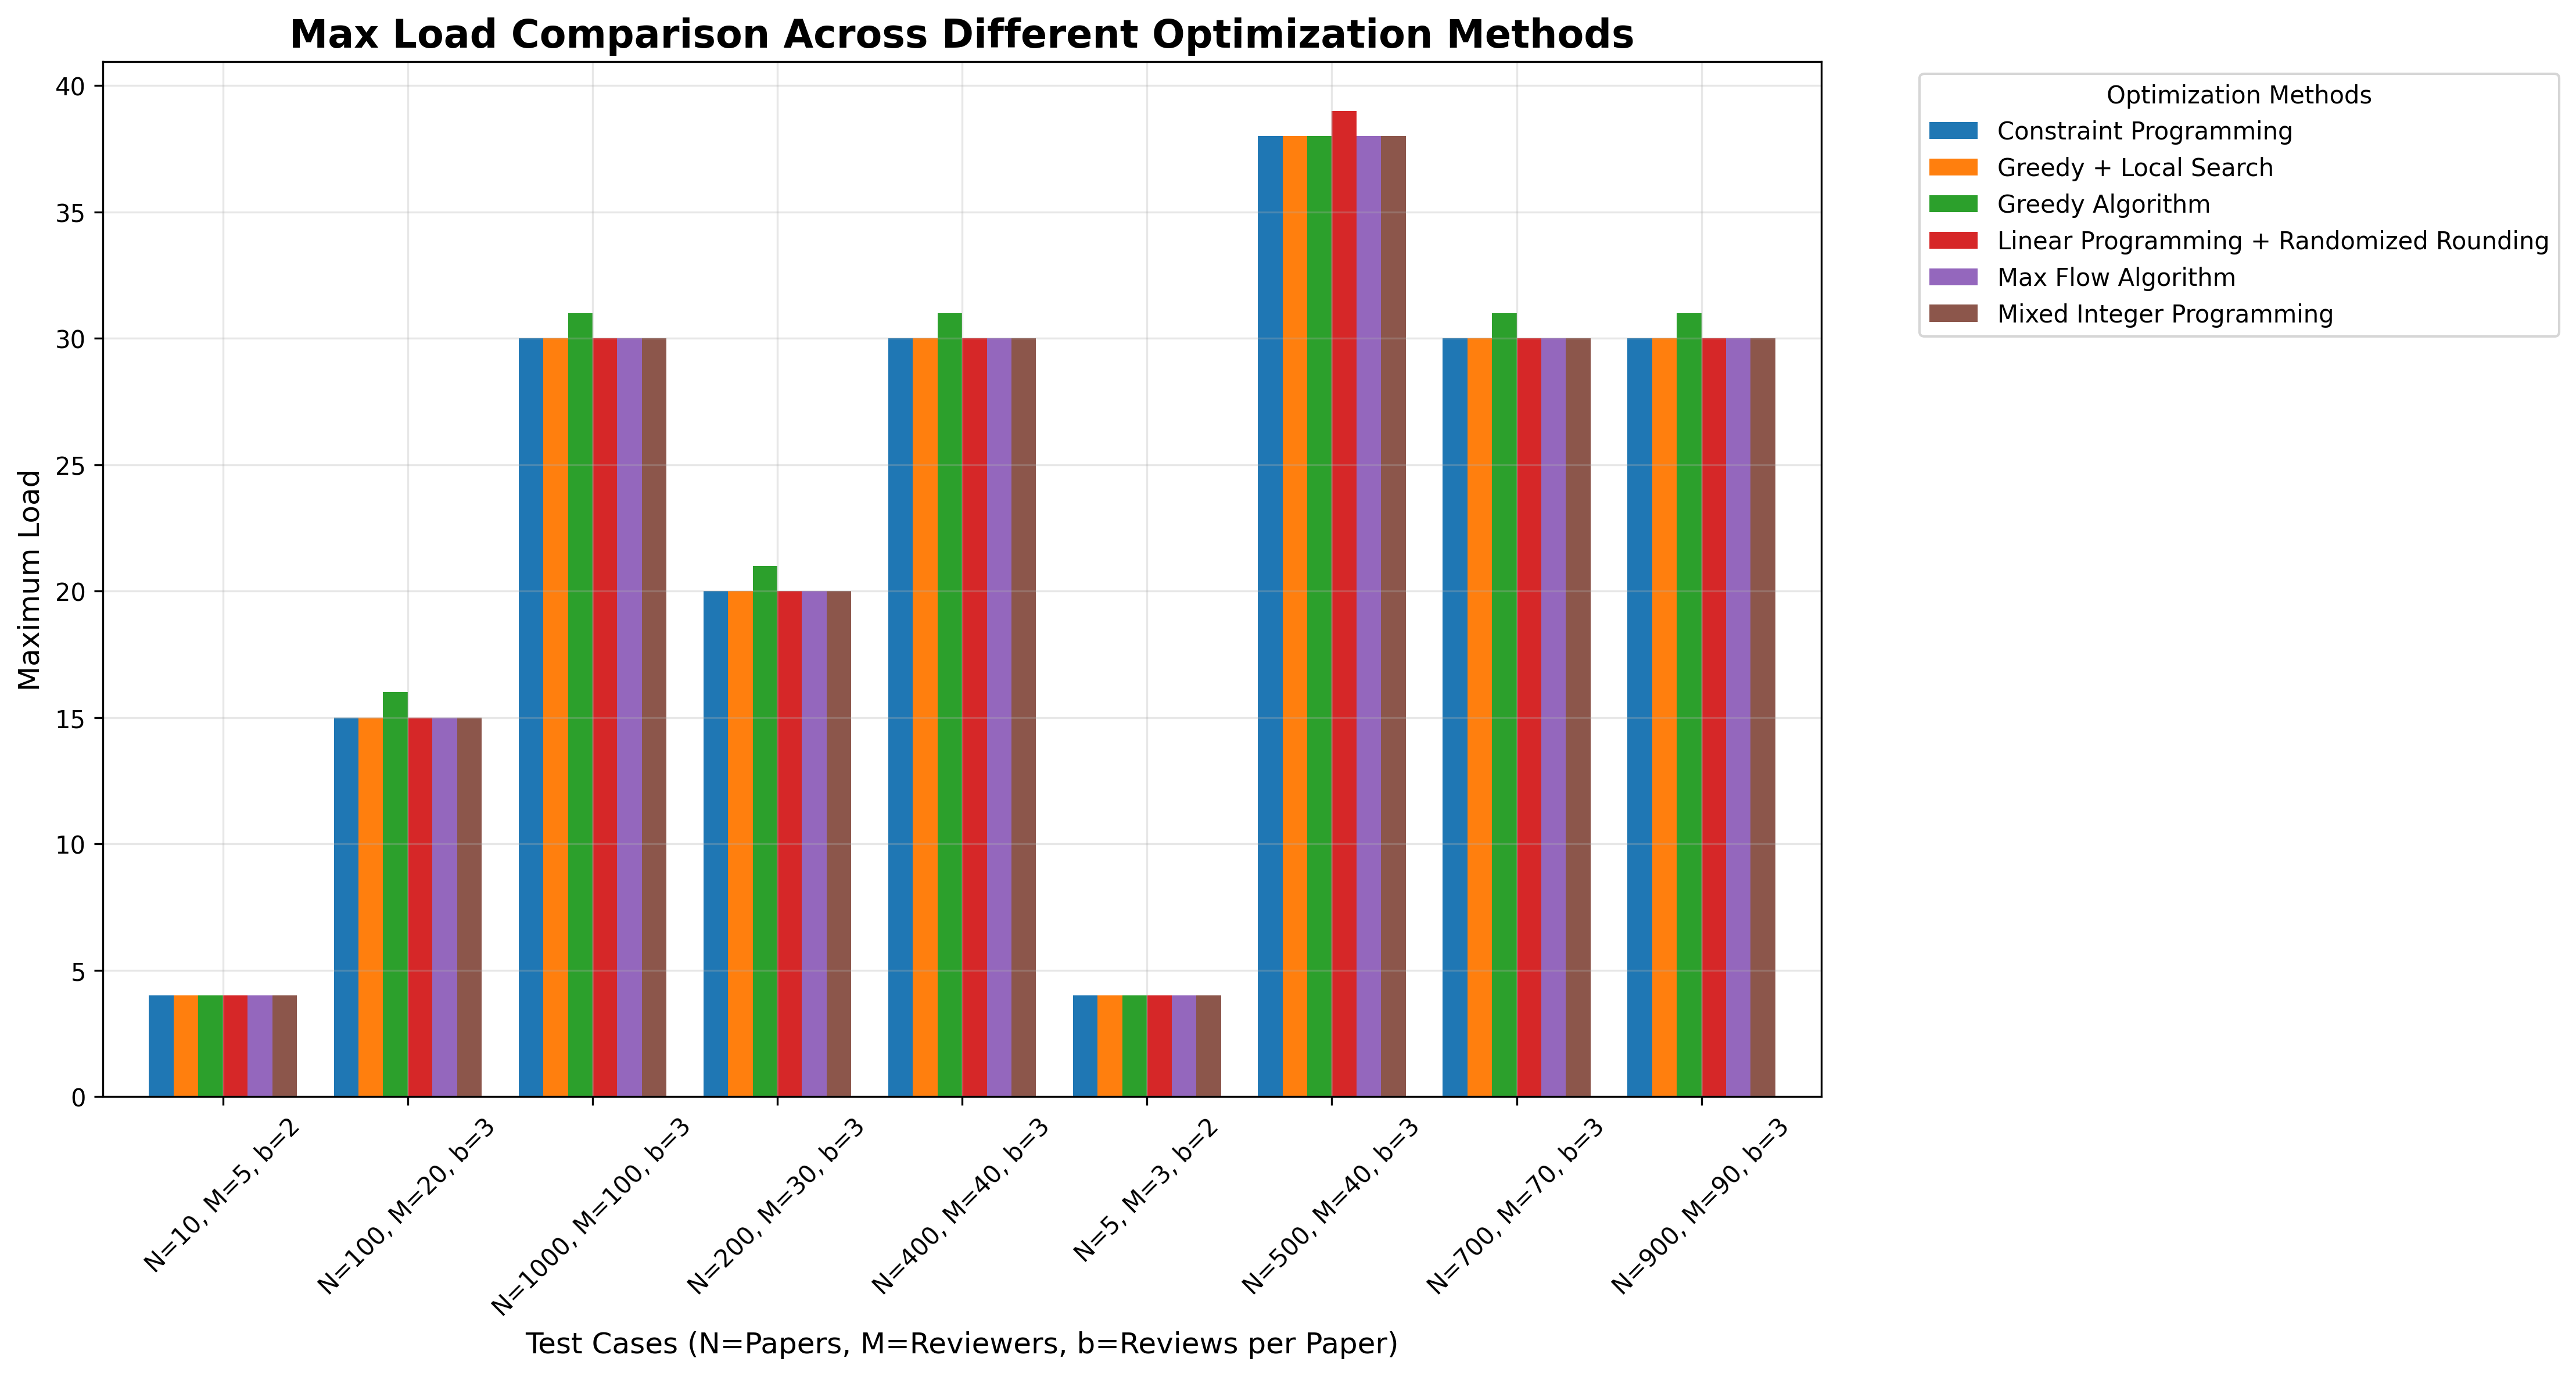
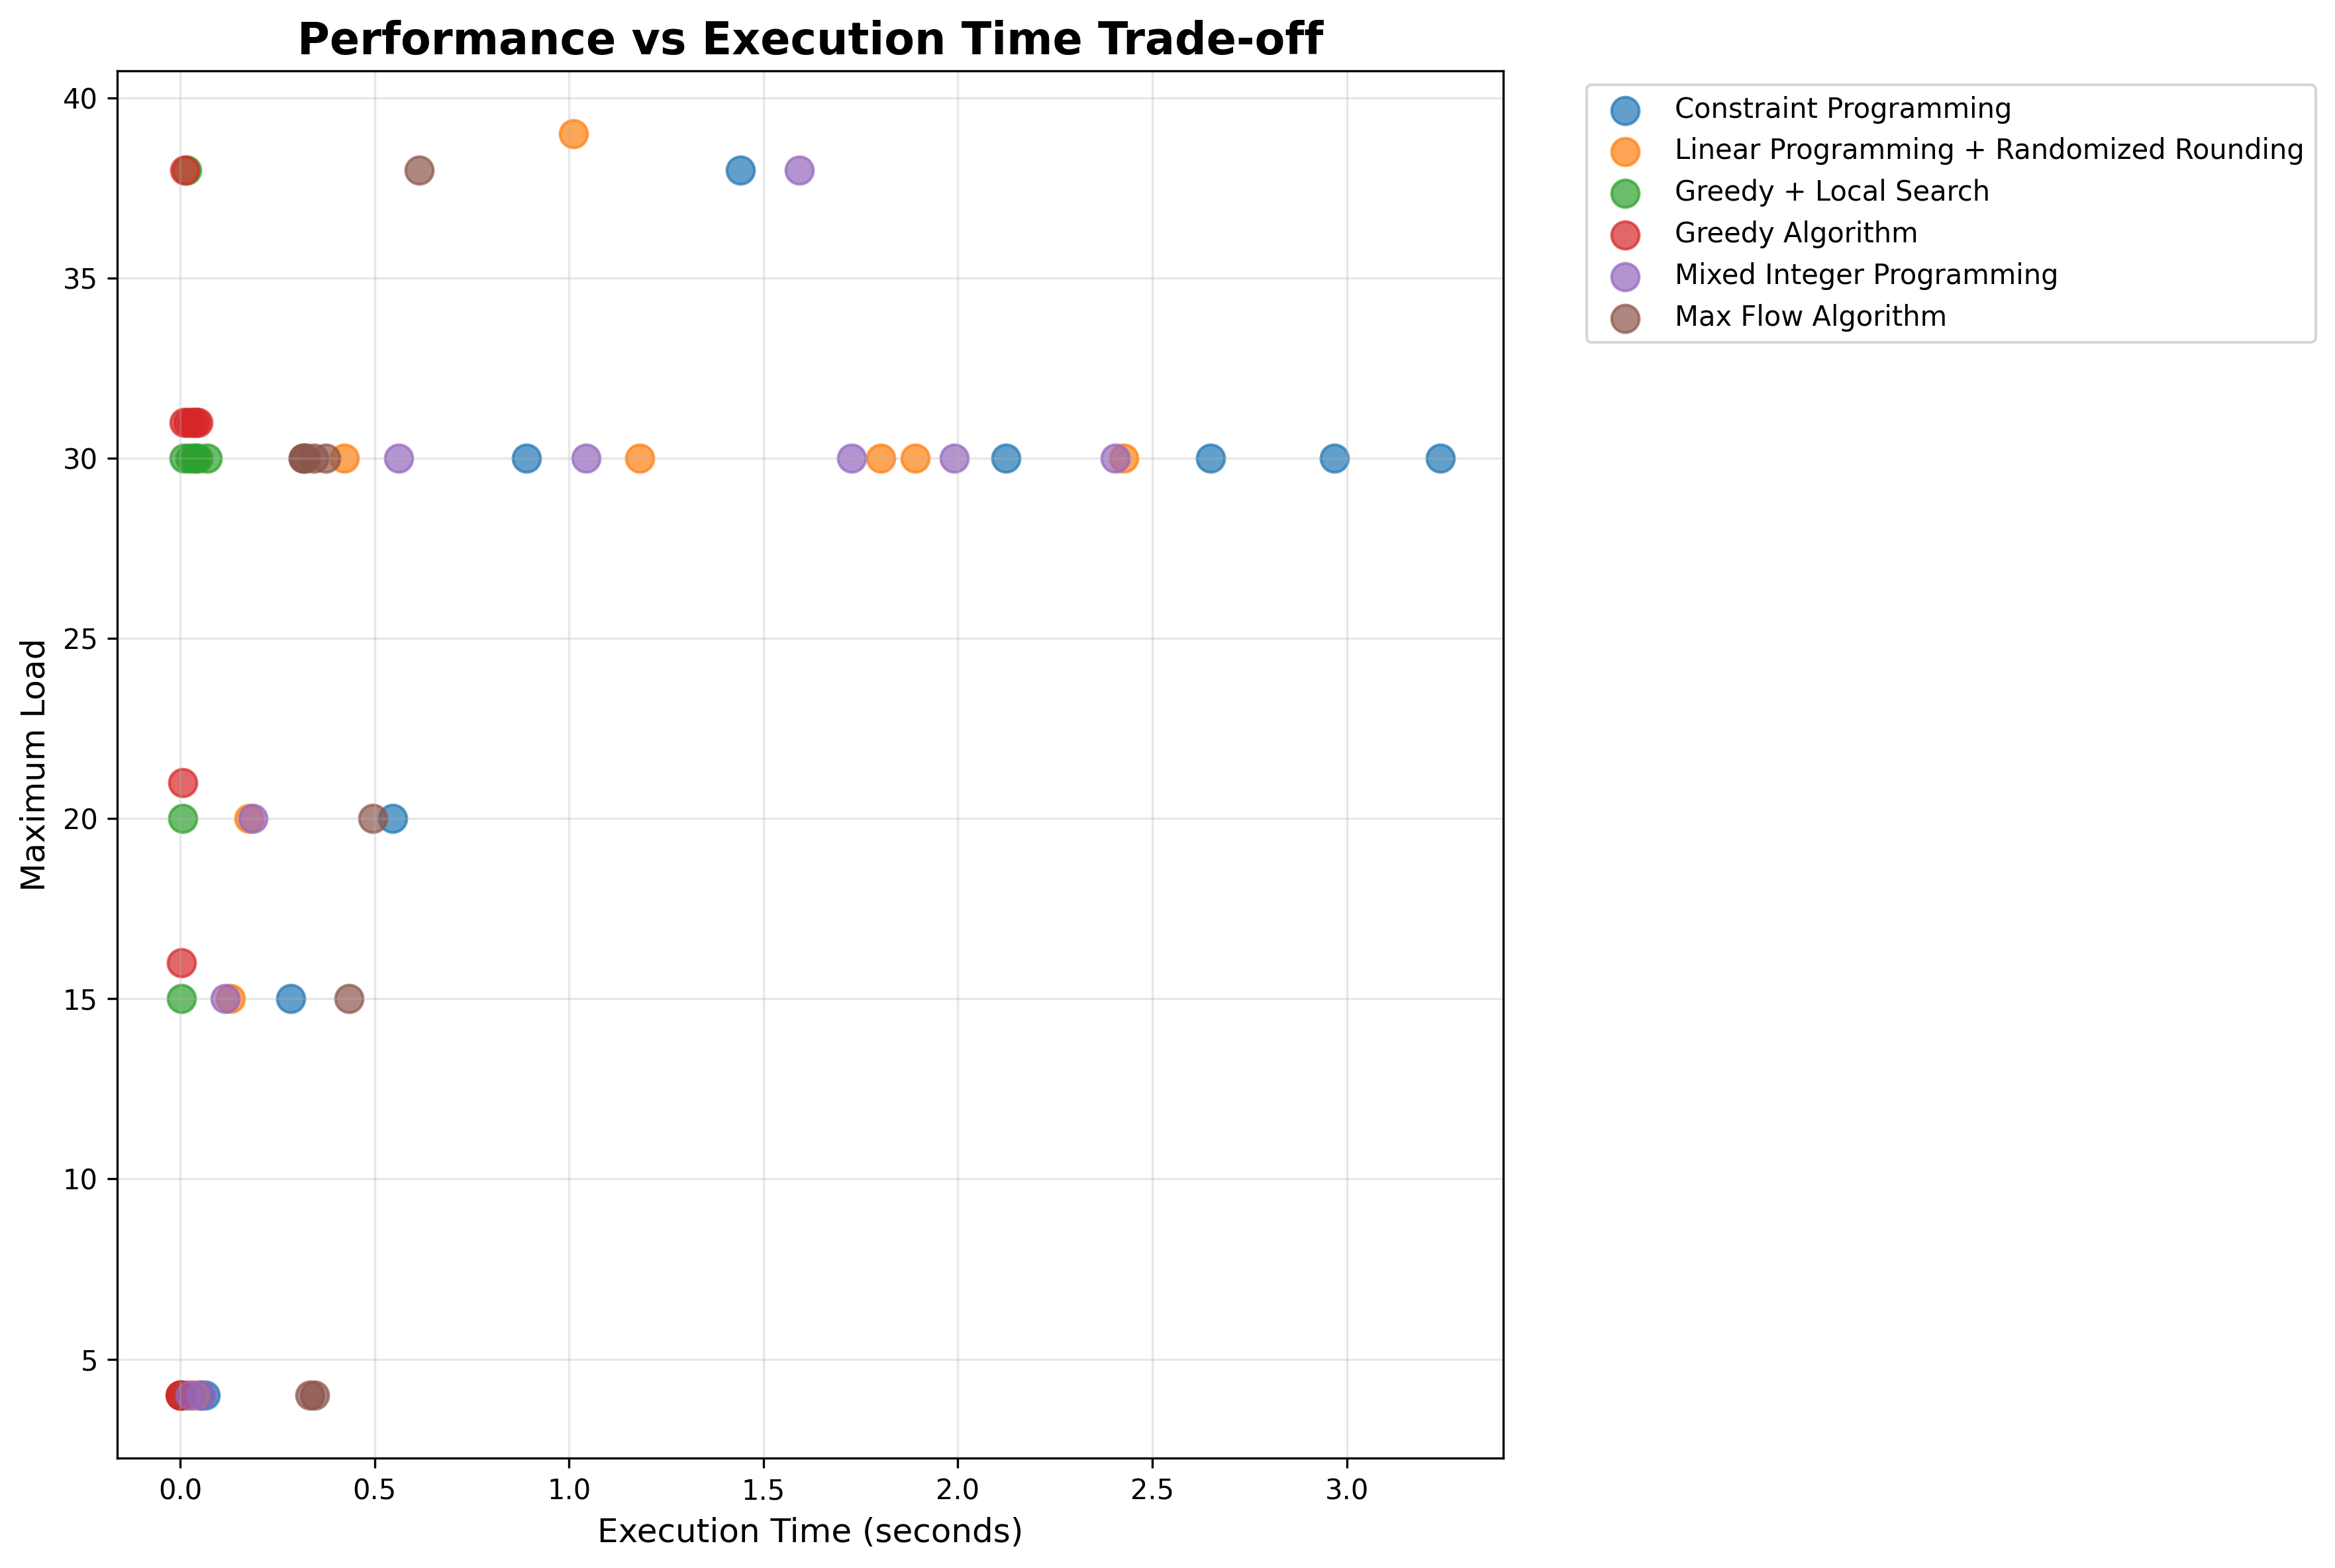

# Conclusion


## References

[1] Approximation Algorithms: LP Relaxation, Rounding, and Randomized Rounding Techniques, My T. Thai
 Techniques https://cise.ufl.edu/~mythai/courses/2007/cis6930/Notes/Rounding.pdf

[2]